# Shoplifting Video Classification using pretrained model

In [1]:
!pip install gdown
import gdown
import zipfile

drive_link = "https://drive.google.com/uc?id=1RFOxWcIM6eh0WUgqiywueHEuGEEzxDY-"  
output_path = "/kaggle/working/shop_dataSet.zip"

gdown.download(drive_link, output_path, quiet=False)

with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall("/kaggle/working")

print("Dataset downloaded and extracted.")

Downloading...
From (original): https://drive.google.com/uc?id=1RFOxWcIM6eh0WUgqiywueHEuGEEzxDY-
From (redirected): https://drive.google.com/uc?id=1RFOxWcIM6eh0WUgqiywueHEuGEEzxDY-&confirm=t&uuid=e0a00e7f-339d-4959-a031-2d4eee467329
To: /kaggle/working/shop_dataSet.zip
100%|██████████| 1.78G/1.78G [00:14<00:00, 125MB/s] 


Dataset downloaded and extracted.


### Importing Libraries

In [2]:
import os
import cv2
import numpy as np
import torch
import random
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

### random seed for reproducibility

In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
torch.manual_seed(seed_constant)

### Dataset Exploration

In [5]:
DATASET_DIR = "/kaggle/working/Shop DataSet"
shop_lifters_dir = os.path.join(DATASET_DIR, "shop lifters")
non_shop_lifters_dir = os.path.join(DATASET_DIR, "non shop lifters")

#print the number of video files in each directory
print(f"Found {len(os.listdir(shop_lifters_dir))} video files in the directory: {shop_lifters_dir}")
print(f"Found {len(os.listdir(non_shop_lifters_dir))} video files in the directory: {non_shop_lifters_dir}")

Found 324 video files in the directory: /kaggle/working/Shop DataSet/shop lifters
Found 531 video files in the directory: /kaggle/working/Shop DataSet/non shop lifters


In [6]:
#inspect a few samples
def inspect_samples(video_dir):
    for video_file in os.listdir(video_dir)[:10]:
        cap = cv2.VideoCapture(os.path.join(video_dir, video_file))
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

        print(f"Video: {video_file}, Width: {frame_width}, Height: {frame_height}, FPS: {frame_rate}, Frames: {frame_count}")


In [7]:
inspect_samples(shop_lifters_dir) #shop lifters directory

Video: videmmmmmmsss_89.mp4, Width: 704, Height: 576, FPS: 24, Frames: 273
Video: videppppsss_34.mp4, Width: 704, Height: 576, FPS: 25, Frames: 400
Video: videyyyyyyyyyss_5.mp4, Width: 704, Height: 576, FPS: 25, Frames: 250
Video: shop_lifter_92.mp4, Width: 704, Height: 576, FPS: 25, Frames: 375
Video: shop_lifter_9.mp4, Width: 704, Height: 576, FPS: 24, Frames: 297
Video: videmmmmmmsss_102.mp4, Width: 704, Height: 576, FPS: 24, Frames: 248
Video: videyyyyyynnnnnnzzzzzyyyss_2.mp4, Width: 704, Height: 576, FPS: 25, Frames: 325
Video: videmmmmmmsss_101.mp4, Width: 704, Height: 576, FPS: 24, Frames: 248
Video: videyyyyyynnnnnnzzzzzyyyss_10.mp4, Width: 704, Height: 576, FPS: 25, Frames: 300
Video: videmmmmmmsss_85.mp4, Width: 704, Height: 576, FPS: 24, Frames: 248


In [8]:
inspect_samples(non_shop_lifters_dir) #non shop lifters directory

Video: shop_lifter_n_177_1.mp4, Width: 704, Height: 576, FPS: 25, Frames: 425
Video: shop_lifter_n_180.mp4, Width: 704, Height: 576, FPS: 25, Frames: 375
Video: shop_lifter_n_131.mp4, Width: 704, Height: 576, FPS: 25, Frames: 325
Video: videppppsss_34.mp4, Width: 704, Height: 576, FPS: 24, Frames: 199
Video: shop_lifter_n_47_1.mp4, Width: 704, Height: 576, FPS: 25, Frames: 525
Video: shop_lifter_n_69_1.mp4, Width: 704, Height: 576, FPS: 25, Frames: 350
Video: shop_lifter_n_189.mp4, Width: 704, Height: 576, FPS: 25, Frames: 200
Video: shop_lifter_n_124.mp4, Width: 704, Height: 576, FPS: 25, Frames: 200
Video: shop_lifter_n_32_1.mp4, Width: 704, Height: 576, FPS: 25, Frames: 375
Video: shop_lifter_n_120_1.mp4, Width: 704, Height: 576, FPS: 25, Frames: 250


### Dataset Preprocessing and preparation

In [9]:
IMAGE_HEIGHT, IMAGE_WIDTH = 112, 112  # Minimum required for r2plus1d_18
SEQUENCE_LENGTH = 16  # Number of frames per video sequence

# Updated Normalization for r2plus1d_18
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),  # Resize to 112x112
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43216, 0.394666, 0.37645],
                         std=[0.22803, 0.22145, 0.216989])
])

CLASSES_LIST = sorted([entry.name for entry in os.scandir(DATASET_DIR) if entry.is_dir()])
print(CLASSES_LIST)

['non shop lifters', 'shop lifters']


In [10]:
# Extract frames function
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    if video_frames_count < SEQUENCE_LENGTH:
        return None  # Drop short videos

    skip_frames_window = max(video_frames_count // SEQUENCE_LENGTH, 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frame = transform(frame)  # Apply transforms
        frames_list.append(frame)

    video_reader.release()

    if len(frames_list) < SEQUENCE_LENGTH:
        return None  # Drop videos with insufficient frames

    frames_tensor = torch.stack(frames_list)  # (T, C, H, W)
    return frames_tensor.permute(1, 0, 2, 3)  # (C, T, H, W) for r2plus1d_18

In [12]:
# Custom Dataset Class
class ShopliftingDataset(Dataset):
    def __init__(self, dataset_dir, classes_list):
        self.video_paths = []
        self.labels = []

        for class_index, class_name in enumerate(classes_list):
            class_dir = os.path.join(dataset_dir, class_name)
            for file_name in os.listdir(class_dir):
                video_path = os.path.join(class_dir, file_name)
                self.video_paths.append(video_path)
                self.labels.append(class_index)

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, index):
        video_path = self.video_paths[index]
        label = self.labels[index]
        frames = frames_extraction(video_path)

        if frames is None:
            return self.__getitem__((index + 1) % len(self.video_paths))  # Handle short videos

        return frames, label

In [15]:
# Load dataset
dataset = ShopliftingDataset(DATASET_DIR, CLASSES_LIST)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
training_setset, val_dataset, testing_setset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed_constant))

# Print the number of samples in each dataset split
print(f"Number of samples in training set: {len(training_setset)}")
print(f"Number of samples in validation set: {len(val_dataset)}")
print(f"Number of samples in test set: {len(testing_setset)}")

train_loader = DataLoader(training_setset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(testing_setset, batch_size=8, shuffle=False)


Number of samples in training set: 598
Number of samples in validation set: 128
Number of samples in test set: 129


### Model Architecture and Training

In [18]:
# Plot loss & performance_score curves
def plot_training(train_losses, train_accuracies , val_losses, val_accuracies):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", color="red")
    plt.plot(val_losses, label="Val Loss", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy", color="blue" )
    plt.plot(val_accuracies, label="Val Accuracy", color="yellow" )
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Curve")

    plt.show()

In [19]:
# Evaluation function
def evaluate_classifier(classifier, data_loader):
    classifier.eval()
    correct, total, running_loss = 0, 0, 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = torch.sigmoid(outputs).round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.detach().cpu().numpy())
            y_pred.extend(preds.detach().cpu().numpy())


    val_loss = running_loss / len(data_loader)
    val_acc = performance_score_score(y_true, y_pred)
    val_prec = precision_score(y_true, y_pred, zero_division=1)
    val_rec = recall_score(y_true, y_pred, zero_division=1)

    return val_loss, val_acc, val_prec, val_rec

Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth
100%|██████████| 120M/120M [00:00<00:00, 207MB/s] 


Epoch 1/5: Train Loss=0.1594, Train Acc=0.9348, Train Precision=0.8968, Train Recall=0.9456, Val Loss=0.0531, Val Acc=0.9844, Val Precision=0.9535, Val Recall=1.0000
Epoch 2/5: Train Loss=0.0783, Train Acc=0.9749, Train Precision=0.9553, Train Recall=0.9833, Val Loss=0.0024, Val Acc=1.0000, Val Precision=1.0000, Val Recall=1.0000
Epoch 3/5: Train Loss=0.0383, Train Acc=0.9967, Train Precision=0.9917, Train Recall=1.0000, Val Loss=0.0169, Val Acc=0.9922, Val Precision=1.0000, Val Recall=0.9756
Epoch 4/5: Train Loss=0.0385, Train Acc=0.9866, Train Precision=0.9793, Train Recall=0.9874, Val Loss=0.2134, Val Acc=0.8828, Val Precision=1.0000, Val Recall=0.6341
Epoch 5/5: Train Loss=0.0253, Train Acc=0.9950, Train Precision=0.9876, Train Recall=1.0000, Val Loss=0.0052, Val Acc=1.0000, Val Precision=1.0000, Val Recall=1.0000
 Learning rate reduced to 5.000000e-05


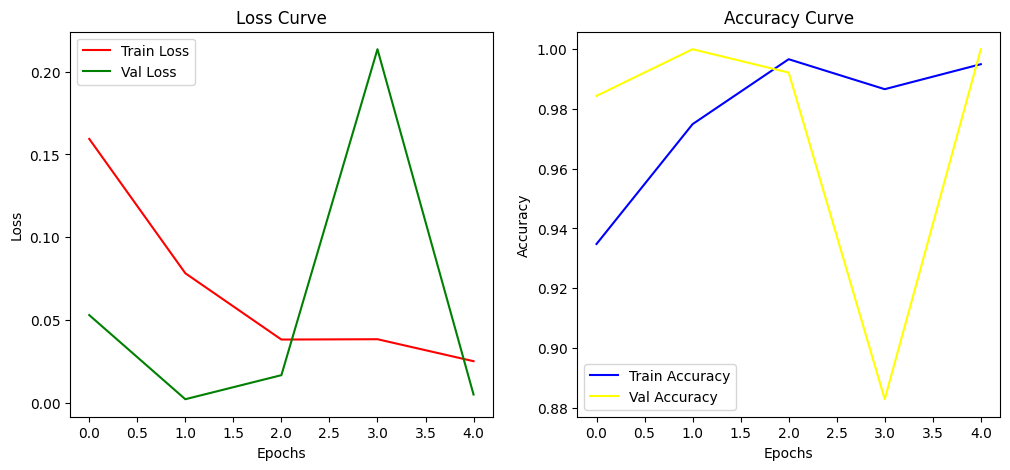

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.classifiers.video as classifiers
import matplotlib.pyplot as plt
from sklearn.metrics import performance_score_score, precision_score, recall_score

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained R2Plus1D-18 classifier
classifier = classifiers.r2plus1d_18(weights="DEFAULT")  # Pretrained weights
classifier.fc = nn.Linear(classifier.fc.in_features, 1)  # Modify final layer for binary classification
classifier = classifier.to(device)

# Loss function & optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)

# Callbacks: Checkpointing, Early Stopping, Reduce LR on Plateau
best_val_loss = float("inf")
patience = 7  # Early stopping patience
no_improve_epochs = 0

# Training function
def train_classifier(classifier, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_precisions, val_precisions = [], []
    train_recalls, val_recalls = [], []

    results = []  # Store epoch-wise results

    for epoch in range(epochs):
        classifier.train()
        running_loss, correct, total = 0.0, 0, 0
        y_true, y_pred = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.sigmoid(outputs).round()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().detach().numpy())
            y_pred.extend(preds.cpu().detach().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_prec = precision_score(y_true, y_pred, zero_division=1)
        train_rec = recall_score(y_true, y_pred, zero_division=1)

        # Validation Step
        val_loss, val_acc, val_prec, val_rec = evaluate_classifier(classifier, val_loader)

        # Store all metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_precisions.append(train_prec)
        val_precisions.append(val_prec)
        train_recalls.append(train_rec)
        val_recalls.append(val_rec)

        # Store results for later printing
        results.append(
            f"Epoch {epoch+1}/{epochs}: "
            f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
            f"Train Precision={train_prec:.4f}, Train Recall={train_rec:.4f}, "
            f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, "
            f"Val Precision={val_prec:.4f}, Val Recall={val_rec:.4f}"
        )

        # Print the latest epoch results
        print(results[-1])

        # Early Stopping & Learning Rate Adjustment
        global best_val_loss, no_improve_epochs
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(classifier.state_dict(), "best_r2plus1d_18_classifier.pth")  # Save best classifier
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print("Early stopping triggered!")
            break

        if no_improve_epochs > 2:  # Reduce LR after 3 bad epochs
            for param_group in optimizer.param_groups:
                param_group["lr"] *= 0.5
                print(f" Learning rate reduced to {param_group['lr']:.6e}")

    # Plot Training Curves
    plot_training(train_losses, train_accuracies , val_losses, val_accuracies)

# Train and evaluate
train_classifier(classifier, train_loader, val_loader, criterion, optimizer, epochs=5)



In [21]:
# Evaluate on test set
test_loss, test_acc, test_prec, test_rec = evaluate_classifier(classifier, test_loader)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Precision: {test_prec:.2f}")
print(f"Test Recall: {test_rec:.2f}")

Test Accuracy: 1.00
Test Precision: 1.00
Test Recall: 1.00
